# trackingML DL with GlueX Fall 2018 data part 2

In this notebook I take the example from the toy4 problem (=ML Challenge 2) and make a complete example for fitting the state vector. This is not the final model and training that we want, but it lays out *a* working example that shows how to deal with a lot of technical details.

In here I make a model that implements a common input section and then 5 separate "legs", one for each of the 5 state vector parameters. The final layer merges these all back into a single, 5-parameter output layer. Note that this does not try to include covariance values in the model output. I'll deal with that in the next part.

A nice thing about this setup is that each parameter has its own dedicated part of the model. Thus, if one parameter needs more layers or a certain structure, it can be fine tuned without affecting the others.

One major improvement here over the toy4 model is that the input data comes in CSV format that removes the need for a generator. This greatly simplifies the code at the expense of making the input features file 2.5 times bigger than raw EVIO data file (50GB vs. 20GB).

Something else implemented here from before is the use of a customized layer that calculates a weighted average. In earlier toy model tests this showed significant improvement in accuracy. The hypothesis is that it includes a division operation which cannot be done with normal layers expect under special conditions. Division could be mimiced using lots of layers in a deeper network, but that would mean more parameters and longer training.

This first section just reads in a portion of the training files and sets a few parameters used later. 

In [1]:
import os
import sys
import gzip
import pandas as pd
import numpy as np
import math

from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Input, Lambda
from tensorflow.keras.optimizers import SGD, Adamax, Adadelta
from tensorflow.keras.callbacks import Callback, TensorBoard
import tensorflow.keras.backend as K
import tensorflow.keras.losses
import tensorflow as tf

TRAIN_FILE  = '/home/davidl/work2/2020.04.30.trackingML/trackingML_features.csv'
LABELS_FILE = '/home/davidl/work2/2020.04.30.trackingML/trackingML_labels.csv'
MAX_TRACKS  = 1000  # Number of tracks(lines) to read from training file

GPUS   = 0  # 0=force CPU, otherwise, the number of GPUs to use
Nouts  = 60 # For Lamda layers that use MyWeightedAvg()

#------------- Define output bin values and ranges
DMIN   = -12.0
DMAX   =  12.0
D_BINSIZE = (DMAX-DMIN)/Nouts

PHIMIN   = -12.0
PHIMAX   =  12.0
PHI_BINSIZE = (PHIMAX-PHIMIN)/Nouts

QOVERPt_MIN   = -12.0
QOVERPt_MAX   =  12.0
QOVERPt_BINSIZE = (QOVERPt_MAX-QOVERPt_MIN)/Nouts

TANLMIN   = -10.0
TANLMAX   =  10.0
TANL_BINSIZE = (TANLMAX-TANLMIN)/Nouts

ZMIN   = -10.0
ZMAX   =  10.0
Z_BINSIZE = (ZMAX-ZMIN)/Nouts
#--------------

# Get fraction of features file read so we can estimate fraction of data we're using
percent_read = 0.0;
with open(TRAIN_FILE) as f:
    f.readline()  # skip header
    for i in range(100): percent_read = percent_read + float(len(f.readline()) + 1)
    percent_read = 100.0*percent_read/os.path.getsize(TRAIN_FILE)*MAX_TRACKS/100.0

# NOTE: Only reading first few rows for now since it takes a long time to read entire file
df       = pd.read_csv(TRAIN_FILE  , nrows=MAX_TRACKS)
labelsdf = pd.read_csv(LABELS_FILE , nrows=MAX_TRACKS)

NINPUTS = len(df.columns)

print('\n\nNumber of input features per track: %d' % NINPUTS)
print('Number of tracks read: %d  ( %3.2f%% of total )' % (len(df.index), percent_read))
print('Label Names: ')
print('              ' + ', '.join(labelsdf.columns[0:1]))
print('              ' + ', '.join(labelsdf.columns[1:6]))
print('              ' + ', '.join(labelsdf.columns[6:11]))
print('              ' + ', '.join(labelsdf.columns[11:16]))
print('              ' + ', '.join(labelsdf.columns[16:21]))
print('              ' + ', '.join(labelsdf.columns[21:]))
print('\n')

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 



Number of input features per track: 5835
Number of tracks read: 1000  ( 0.06% of total )
Label Names: 
              event
              q_over_pt, phi, tanl, D, z
              cov_00, cov_01, cov_02, cov_03, cov_04
              cov_11, cov_12, cov_13, cov_14, cov_22
              cov_23, cov_24, cov_33, cov_34, cov_44
              chisq, Ndof




## Model Layer Definition

This section defines the layers of the model. It actually just defines some procedures that aren't executed until a couple of cells later. (That is when any errors will come up.)

To make things easier to maintain, different parts of the model are defined in different procedures. The structure is shown in the diagram below. Note that these make use of a Lambda layer which uses the MyWeightedAvg procedure defined at the bottom of the cell. Lamda's are nice for making simple custom layers without the complexity of full custom layers.

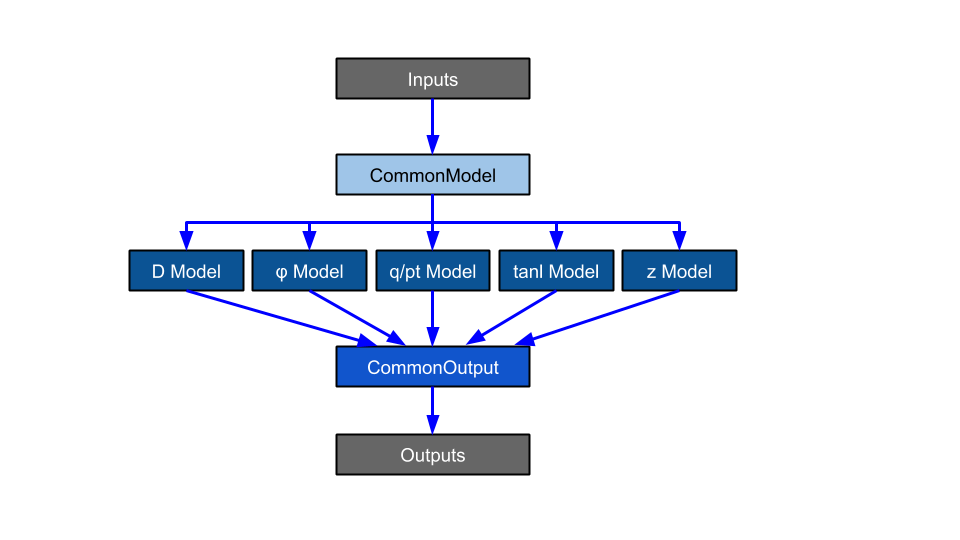


In [2]:
#-----------------------------------------------------
# DefineCommonModel
#-----------------------------------------------------
def DefineCommonModel(inputs):
    x = Flatten(name='top_layer1')(inputs)
    x = Dense(int(Nouts*5), name='common_layer1', activation='linear', kernel_initializer="glorot_uniform")(x)
    return x

#-----------------------------------------------------
# DefineDModel
#-----------------------------------------------------
def DefineDModel(inputs):
    x = Dense(Nouts, name='D_output_dist', activation='relu', kernel_initializer="glorot_uniform")(inputs)
    x = Lambda(MyWeightedAvg, output_shape=(1,), name='D_output', arguments={'binsize':D_BINSIZE, 'xmin':DMIN})(x)
    return x

#-----------------------------------------------------
# DefinePhiModel
#-----------------------------------------------------
def DefinePhiModel(inputs):
    x = Dense(Nouts, name='phi_output_dist', activation='relu', kernel_initializer="glorot_uniform")(inputs)
    x = Lambda(MyWeightedAvg, output_shape=(1,), name='phi_output', arguments={'binsize':PHI_BINSIZE, 'xmin':PHIMIN})(x)
    return x

#-----------------------------------------------------
# Define_q_over_pt_Model
#-----------------------------------------------------
def Define_q_over_pt_Model(inputs):
    x = Dense(Nouts, name='q_over_pt_output_dist', activation='relu', kernel_initializer="glorot_uniform")(inputs)
    x = Lambda(MyWeightedAvg, output_shape=(1,), name='q_over_pt_output', arguments={'binsize':QOVERPt_BINSIZE, 'xmin':QOVERPt_MIN})(x)
    return x

#-----------------------------------------------------
# Define_tanl_Model
#-----------------------------------------------------
def Define_tanl_Model(inputs):
    x = Dense(Nouts, name='tanl_output_dist', activation='relu', kernel_initializer="glorot_uniform")(inputs)
    x = Lambda(MyWeightedAvg, output_shape=(1,), name='tanl_output', arguments={'binsize':TANL_BINSIZE, 'xmin':TANLMIN})(x)
    return x

#-----------------------------------------------------
# DefineZModel
#-----------------------------------------------------
def DefineZModel(inputs):
    x = Dense(Nouts, name='z_output_dist', activation='relu', kernel_initializer="glorot_uniform")(inputs)
    x = Lambda(MyWeightedAvg, output_shape=(1,), name='z_output', arguments={'binsize':Z_BINSIZE, 'xmin':ZMIN})(x)
    return x

#-----------------------------------------------------
# DefineCommonOutput
#-----------------------------------------------------
def DefineCommonOutput(inputs):
    x = tf.keras.layers.concatenate( inputs )
    x = Dense(5, name='outputs', activation='relu', kernel_initializer="glorot_uniform")(x)
    return x

#-----------------------------------------------------
# MyWeightedAvg
#
# This is used by the final Lambda layer in each branch
# of the network. It defines the formula for calculating
# the weighted average of the inputs from the previous
# layer.
#-----------------------------------------------------
def MyWeightedAvg(inputs, binsize, xmin):
    ones = K.ones_like(inputs[0,:])                       # [1, 1, 1, 1....]   (size Nouts)
    idx  = K.cumsum(ones)                                 # [1, 2, 3, 4....]   (size Nouts)
    norm = K.sum(inputs, axis=1, keepdims=True)           # normalization of all outputs by batch. shape is 1D array of size batch (n.b. keepdims=True is critical!)
    wsum = K.sum(idx*inputs, axis=1, keepdims=True)/norm  # array of size batch with weighted avg. of mean in units of bins (n.b. keepdims=True is critical!)
    output = (binsize*(wsum-0.5)) + xmin                  # convert from bins to physical units (shape batch,1)

    print('MyWeightedAvg:')
    print('       binsize = %f' % binsize)
    print('          xmin = %f' % xmin)
    print('   input shape = %s' % str(inputs.shape))
    print('  output shape = %s' % str(output.shape))

    return output


## Define Model

The full model is put together here using the parts defined in the previous cell. It also defines weights for the trivial loss function used. The weights are used here as a way of scaling the loss for each of the state parameters by $1/\sigma_i$ to account for the different units and uncertainties. This is actually not going to be sufficient in the end where full custom loss function will be required. It at least gives a simple example that can be used for the this.

In [3]:
#-----------------------------------------------------
# DefineModel
#-----------------------------------------------------
# This is used to define the model. It is only called if no model
# file is found in the model_checkpoints directory.
def DefineModel():

    # If GPUS==0 this will force use of CPU, even if GPUs are present
    # If GPUS>1 this will force the CPU to serve as orchestrator
    # If GPUS==1 this will do nothing, allowing GPU to act as its own orchestrator
    if GPUS!=1: tf.device('/cpu:0')

    # Here we build the network model.
    # This model is made of multiple parts. The first handles the
    # inputs and identifies common features. The rest are branches with
    # each determining an output parameter from those features.
    inputs         = Input(shape=(NINPUTS,), name='image_inputs')
    commonmodel    = DefineCommonModel(inputs)
    Dmodel         = DefinePhiModel(         commonmodel )
    phimodel       = DefineDModel(           commonmodel )
    q_over_ptmodel = Define_q_over_pt_Model( commonmodel )
    tanlmodel      = Define_tanl_Model(      commonmodel )
    zmodel         = DefineZModel(           commonmodel )
    commonoutput   = DefineCommonOutput([Dmodel, phimodel, q_over_ptmodel, tanlmodel, zmodel])
    model          = Model(inputs=inputs, outputs=commonoutput)

    # Here we specify a different loss function for every output branch.
    # We also specify a weight for each branch. The weights allow us to 
    # specify that it is more important to minimize certain losses more
    # than others.
    sigma_D = 0.011    # placeholder
    sigma_phi = 0.011  # estimated resolution in degrees (from previous training)
    sigma_q_over_pt = 0.011    # placeholder
    sigma_tanl = 0.011    # placeholder
    sigma_z   = 0.100  # estimated resolution in cm (from previous training)
    
    # These need to be replaced by custom loss functions that can calculate
    # the sigmas based on the state vector.
    lossWeights = {
        'D_output'         :  1.0/(sigma_D*sigma_D),
        'phi_output'       :  1.0/(sigma_phi*sigma_phi),
        'q_over_pt_output' :  1.0/(sigma_q_over_pt*sigma_q_over_pt),
        'tanl_output'      :  1.0/(sigma_tanl*sigma_tanl),
        'z_output'         :  1.0/(sigma_z*sigma_z),
    }
    
    # It makes it easier if the output of the model is a simple array of 5
    # values corresponding to the values in the labels file, in the same
    # order. This next bit is just so we can put the loss weights in a list
    # of the right order.
    outNames = ['D_output', 'phi_output', 'q_over_pt_output', 'tanl_output', 'z_output']  # names in order of model outputs
    lossWeights_list = []
    for n in outNames: lossWeights_list.append(lossWeights[n])

    # Compile the model, possibly using multiple GPUs
    opt = Adadelta(clipnorm=1.0)
    if GPUS<=1 :
        final_model = model
    else:
        final_model = multi_gpu_model( model, gpus=GPUS )

    final_model.compile(loss='mse', loss_weights=[lossWeights_list], optimizer=opt, metrics=['mae', 'mse', 'accuracy'])
    
    return final_model


## Load or Build model

I have found in the past that it is often good to be able to load a model that has undergone some training and continue training it. In addition, it is useful if you can keep track of how many epochs total were used in the training. In this cell, I look for the most recent model file and load it, if found. If no model file is found, then the model is defined using the above routines.

Note that at the end of this the "epochs_loaded" parameter will be set to the number of epochs completed already for this model (0 if it is new). This number is passed into the fit call later so it displays the right thing and, in turn, passes it to the routine that saves the model periodically so that it can name the file properly.

In [4]:
# Here we want to check if a model has been saved due to previous training.
# If so, then we read it in and continue training where it left off. Otherwise,
# we define the model and start fresh. 

# Look for most recent saved epoch
epoch_loaded = -1
if os.path.exists('model_checkpoints'):
    for f in os.listdir('model_checkpoints'):
        if f.startswith('model_epoch') and f.endswith('.h5'):
            e = int(f[11:-3])
            if e > epoch_loaded:
                epoch_loaded = e
                fname = 'model_checkpoints/model_epoch%03d.h5' % epoch_loaded

if epoch_loaded > 0:
    print('Loading model: ' + fname)
    model = load_model( fname )
else:
    print('Unable to find saved model. Will start from scratch')
    model = DefineModel()
    epoch_loaded = 0

# Print summary of model
model.summary()

Unable to find saved model. Will start from scratch
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
MyWeightedAvg:
       binsize = 0.400000
          xmin = -12.000000
   input shape = (?, 60)
  output shape = (?, 1)
MyWeightedAvg:
       binsize = 0.400000
          xmin = -12.000000
   input shape = (?, 60)
  output shape = (?, 1)
MyWeightedAvg:
       binsize = 0.400000
          xmin = -12.000000
   input shape = (?, 60)
  output shape = (?, 1)
MyWeightedAvg:
       binsize = 0.333333
          xmin = -10.000000
   input shape = (?, 60)
  output shape = (?, 1)
MyWeightedAvg:
       binsize = 0.333333
          xmin = -10.000000
   input shape = (?, 60)
  output shape = (?, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_inputs (InputLayer)  

## Fit the model

First I define the checkpoint routine that will save the full model after every epoch so we always have the latest model saved. It also removes the previous model since the disk space usage can get quite large otherwise.

The "EPOCHS" and "BS" variables can be used to set the total number of epochs to train and the batch size respectively. Note that I only do a few epochs here since it prints a few lines for each which will blow up the output when the fit is done if a lot more are used. This at least proves that it works.


In [5]:
#-----------------------------------------------------
# class checkpointModel
#-----------------------------------------------------
# There is a bug in keras that causes an error when trying to save a model
# trained on multiple GPUs. The work around is to save the original model
# at the end of every epoch using a callback. See
#    https://github.com/keras-team/kersas/issues/8694
if not os.path.exists('model_checkpoints'): os.mkdir('model_checkpoints')
class checkpointModel(Callback):
    def __init__(self, model):
        self.model_to_save = model
    def on_epoch_end(self, epoch, logs=None):
        myepoch = epoch_loaded + epoch +1
        fname = 'model_checkpoints/model_epoch%03d.h5' % myepoch
        old_fname = 'model_checkpoints/model_epoch%03d.h5' % (myepoch-1)
        if os.path.exists( old_fname ):
            print('removing old model: %s' % old_fname)
            os.remove( old_fname )
        print('saving model: %s' % fname)
        self.model_to_save.save(fname)
cbk = checkpointModel( model )

cbk.on_epoch_end(-1)

EPOCHS = 3
BS     = 1000

# Fit the model
history = model.fit(
    x = df,
    y = labelsdf.iloc[:, 1:6],  # Peel off only 5 state vector parameters
    batch_size = BS,
    epochs=EPOCHS,
    callbacks=[cbk],
    validation_split=0.2,
    shuffle=True,
    initial_epoch = epoch_loaded,
    use_multiprocessing=False
)


saving model: model_checkpoints/model_epoch000.h5
Train on 800 samples, validate on 200 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/3
removing old model: model_checkpoints/model_epoch000.h5
saving model: model_checkpoints/model_epoch001.h5
800/800 [==============================] - 1s 932us/sample - loss: 41217056.0000 - mean_absolute_error: 25.2073 - mean_squared_error: 6215.2788 - acc: 0.0088 - val_loss: 13691478.0000 - val_mean_absolute_error: 21.1145 - val_mean_squared_error: 2064.5908 - val_acc: 0.0350
Epoch 2/3
removing old model: model_checkpoints/model_epoch001.h5
saving model: model_checkpoints/model_epoch002.h5
800/800 [==============================] - 0s 449us/sample - loss: 41216136.0000 - mean_absolute_error: 25.2042 - mean_squared_error: 6215.1392 - acc: 0.0088 - val_loss: 13690752.0000 - val_mean_absolute_error: 21.1116 - val_mean_squared_error: 2064.4812 - val_acc: 0.0350
Epoch 3/3
removing old model: mo